# Motive / Optitrack to OpenEphys alignment
Assumes a TTL from Motive to OpenEphys at the start of each recording. If it doesn't find that, will try to align by timestamps.

IMPORTANT NOTE: Watch out for any warnings about start time having "second precision" when creating the `sync_df` DataFrame below, this will percolate through to all synchronized devices.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy/'])  # Add path to NeuroPy repository here
sys.path.extend(['/data/GitHub/NeuroPy/'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.optitrackio import OptitrackIO
import neuropy.io.openephysio as oeio
from neuropy.core.epoch import Epoch

## Load in session data and Open Ephys timestamps

In [2]:
dir_use = Path("/data3/Psilocybin/Recording_Rats/Finn2/2023_05_24_saline1/")
sess = core.ProcessData(dir_use)

# Create sync_df to ID start and end of each recording in concatenated .eeg file
sync_df = oeio.create_sync_df(dir_use)

# Get absolute time from start of first recording
sync_df['Tabs from start (s)'] = (sync_df['Datetime'] - sync_df['Datetime'].iloc[0]).dt.total_seconds()
sync_df

start time = 2023-05-24 11:52:10.443961-04:00
start time = 2023-05-24 11:54:28.668011-04:00
start time = 2023-05-24 12:08:55.977151-04:00
start time = 2023-05-24 13:14:01.106690-04:00
start time = 2023-05-24 13:56:04.339061-04:00
start time = 2023-05-24 14:38:18.999980-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Tabs from start (s)
0,0,2023-05-24 11:52:10.443961-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2023-05-24 11:53:41.016727667-04:00,stop,2717183,90.572767,113215,90.5720,90.572767
2,1,2023-05-24 11:54:28.668011-04:00,start,2717184,90.572800,113216,90.5728,138.224050
3,1,2023-05-24 12:04:58.197577667-04:00,stop,21603071,720.102367,900127,720.1016,767.753617
4,2,2023-05-24 12:08:55.977151-04:00,start,21603072,720.102400,900128,720.1024,1005.533190
5,2,2023-05-24 13:13:29.018184333-04:00,stop,137794303,4593.143433,5741429,4593.1432,4878.574223
6,3,2023-05-24 13:14:01.106690-04:00,start,137794304,4593.143467,5741430,4593.1440,4910.662729
7,3,2023-05-24 13:55:24.886923333-04:00,stop,212307711,7076.923700,8846154,7076.9232,7394.442962
8,4,2023-05-24 13:56:04.339061-04:00,start,212307712,7076.923733,8846155,7076.9240,7433.895100
9,4,2023-05-24 14:36:30.459561-04:00,stop,285091327,9503.044233,11878805,9503.0440,9860.015600


## Next get OptiTrack recording start

### Method 1: Calculate from .tak file modification time and # frames in .avi file(no rigid body tracking or .csv file, ~millisecond precision?).

This method is used for synchronizing below...

In [3]:
from datetime import datetime
from neuropy.io.dlcio import DLC
import os

tak_file_dir = Path("/run/media/nkinsky/LWD_Backup/Nat/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")
dlc_file_dir = Path("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")

if not (sess.basepath / "inferred_start_time.csv").exists():

    tak_files = sorted(tak_file_dir.glob("**/*.tak"))
    
    mtimes = []
    for tak_file in tak_files:
        mtimes.append(pd.Timestamp(datetime.fromtimestamp(os.path.getmtime(tak_file))))
    
    dlc = DLC(dlc_file_dir, movie_type=".avi")
    
    opti_sr = dlc.SampleRate
    mtimes
else:
    print("inferred_start_time.csv file already exists. Load in below")

inferred_start_time.csv file already exists. Load in below


In [6]:
from neuropy.io.movie import tracking_movie

tz = "America/Detroit"
if (sess.basepath / "inferred_start_time.csv").exists():
    print("inferred_start_time.csv file already exists. Load in below")
else:
    start_times, nframes, samplerate = [], [], []
    for tak_file, mtime in zip(tak_files, mtimes):
        try:
            movie_file = sorted(tak_file.parent.glob(f"{tak_file.stem}*.avi"))[0]
            mobj = tracking_movie(str(movie_file))
            start_times.append((mtime - pd.Timedelta(mobj.nframes / dlc.SampleRate, unit="sec")).tz_localize(tz))
            nframes.append(mobj.nframes)
            samplerate.append(mobj.SampleRate)
        except IndexError:
            start_times.append(np.nan)
            nframes.append(np.nan)
            samplerate.append(np.nan)
    
    start_times

inferred_start_time.csv file already exists. Load in below


In [25]:
if not (sess.basepath / "inferred_start_time.csv").exists():
    start_time_df = pd.DataFrame({"file": [tak_file.stem for tak_file in tak_files], 
                                  "mod_time": mtimes,
                                  "inferred_start_time": start_times,
                                  "nframes": nframes,
                                  "SampleRate": samplerate,
                                  "Opti_Recording": np.arange(len(tak_files))})
    
    start_time_df.to_csv(sess.basepath / "inferred_start_time.csv")
else:
    print("Adding in fields and converting to timestamps")
    start_time_df = pd.read_csv(sess.basepath / "inferred_start_time.csv", index_col=0, parse_dates=["mod_time", "inferred_start_time"])
    start_time_df = start_time_df.sort_values(by="mod_time", ignore_index=True)
    try:
        start_time_df["mod_time"] = pd.to_datetime(start_time_df["mod_time"]).dt.tz_localize(tz)
    except TypeError:
        pass
    try:
        start_time_df["inferred_start_time"] = pd.to_datetime(start_time_df["inferred_start_time"]).dt.tz_localize(tz)
    except TypeError:
        pass
start_time_df

Adding in fields and converting to timestamps


,file,mod_time,inferred_start_time,nframes,SampleRate,Opti_Recording
0,Take 2023-05-24 11.52.50 AM,2023-05-24 11:54:22.262668-04:00,2023-05-24 11:52:51.129334667-04:00,2734.0,30.0,0
1,Take 2023-05-24 11.54.39 AM,2023-05-24 12:04:44.648913-04:00,2023-05-24 11:54:40.015579667-04:00,18139.0,30.0,1
2,Take 2023-05-24 12.09.45 PM,2023-05-24 12:41:49.856936-04:00,2023-05-24 12:09:45.990269333-04:00,57716.0,30.0,2
3,Take 2023-05-24 12.42.02 PM,2023-05-24 13:07:53.762076-04:00,2023-05-24 12:42:03.295409333-04:00,46514.0,30.0,3
4,Take 2023-05-24 01.08.00 PM,2023-05-24 13:15:47.201988-04:00,NaT,NaN,NaN,4
5,Take 2023-05-24 01.25.50 PM,2023-05-24 13:55:22.836704-04:00,2023-05-24 13:25:52.003370667-04:00,53125.0,30.0,5
6,Take 2023-05-24 01.56.43 PM,2023-05-24 14:21:23.862917-04:00,2023-05-24 13:56:44.896250333-04:00,44369.0,30.0,6
7,Take 2023-05-24 02.21.35 PM,2023-05-24 14:36:28.551181-04:00,2023-05-24 14:21:36.484514333-04:00,26762.0,30.0,7
8,Take 2023-05-24 02.38.40 PM,2023-05-24 14:59:03.229051-04:00,2023-05-24 14:38:41.695717668-04:00,36646.0,30.0,8


In [27]:
# Add in nframes and SampleRate if missing from start_time_df and re-save
movie_dir = Path("/run/media/nkinsky/Nat1/Psilocybin/Recording_Rats/Finn2/2023_05_24_saline1")
if "nframes" not in start_time_df.keys():
    nframes, samplerate = [], []
    for file_stem in start_time_df.file.values:
        try:
            movie_file = movie_dir / f"{file_stem}-Camera 4 (#410110).avi"
            mobj = tracking_movie(str(movie_file))
            # start_times.append((mtime - pd.Timedelta(mobj.nframes / dlc.SampleRate, unit="sec")).tz_localize(tz))
            nframes.append(mobj.nframes)
            samplerate.append(mobj.SampleRate)
        except IndexError:
            start_times.append(np.nan)
            nframes.append(np.nan)
            samplerate.append(np.nan)
    start_time_df["nframes"] = nframes
    start_time_df["SampleRate"] = samplerate
    start_time_df["Opti_Recording"] = np.arange(start_time_df.shape[0])
    start_time_df.to_csv(sess.basepath / "inferred_start_time.csv")
else:
    print("nframes and SampleRate already in df")
start_time_df

nframes and SampleRate already in df


,file,mod_time,inferred_start_time,nframes,SampleRate,Opti_Recording
0,Take 2023-05-24 11.52.50 AM,2023-05-24 11:54:22.262668-04:00,2023-05-24 11:52:51.129334667-04:00,2734.0,30.0,0
1,Take 2023-05-24 11.54.39 AM,2023-05-24 12:04:44.648913-04:00,2023-05-24 11:54:40.015579667-04:00,18139.0,30.0,1
2,Take 2023-05-24 12.09.45 PM,2023-05-24 12:41:49.856936-04:00,2023-05-24 12:09:45.990269333-04:00,57716.0,30.0,2
3,Take 2023-05-24 12.42.02 PM,2023-05-24 13:07:53.762076-04:00,2023-05-24 12:42:03.295409333-04:00,46514.0,30.0,3
4,Take 2023-05-24 01.08.00 PM,2023-05-24 13:15:47.201988-04:00,NaT,NaN,NaN,4
5,Take 2023-05-24 01.25.50 PM,2023-05-24 13:55:22.836704-04:00,2023-05-24 13:25:52.003370667-04:00,53125.0,30.0,5
6,Take 2023-05-24 01.56.43 PM,2023-05-24 14:21:23.862917-04:00,2023-05-24 13:56:44.896250333-04:00,44369.0,30.0,6
7,Take 2023-05-24 02.21.35 PM,2023-05-24 14:36:28.551181-04:00,2023-05-24 14:21:36.484514333-04:00,26762.0,30.0,7
8,Take 2023-05-24 02.38.40 PM,2023-05-24 14:59:03.229051-04:00,2023-05-24 14:38:41.695717668-04:00,36646.0,30.0,8


### Method 2: From .csv file output from .tak file (microsecond precision)
Note that lag from start time logged in .tak file to actual recording start time can be ~1.5 seconds.  

Not used below.

In [ ]:
csv_path = "/data2/Alternation/Recording_Rats/Finn/2022_02_01_alternation2/1_alternation/"
opti = OptitrackIO(csv_path)
tstart_from_csv = opti.datetime_array[0]
tstart_from_csv

## Method 1: Motive start triggers some TTLs (but not all) at start only.
Example: Motive start triggers miniscope data acquisition which delivers a TTL for each frame acquired. Therefore the start of a TTL block can coincide with a Motive recording start, but in case of a disconnect we may a miniscope recording restart without restarting Motive.

In [15]:
# Load in ALL TTLs
ttl_start_chan_use = 1
ttl_df = oeio.load_all_ttl_events(dir_use)
ttl_df = ttl_df[ttl_df.channel_states.abs() == ttl_start_chan_use]
ttl_df

,channel_states,timestamps,datetimes,sample_number,event_name,Recording
0,-1,1226618,2023-05-24 11:52:51.331227667-04:00,1226618,,0
1,1,1228599,2023-05-24 11:52:51.397261-04:00,1228599,,0
2,-1,1230647,2023-05-24 11:52:51.465527667-04:00,1230647,,0
3,1,1232638,2023-05-24 11:52:51.531894333-04:00,1232638,,0
4,-1,1234660,2023-05-24 11:52:51.599294333-04:00,1234660,,0
...,...,...,...,...,...,...
14570,-1,37263130,2023-05-24 14:59:01.104313333-04:00,322354458,,5
14571,1,37265151,2023-05-24 14:59:01.171680-04:00,322356479,,5
14572,-1,37267203,2023-05-24 14:59:01.240080-04:00,322358531,,5
14573,1,37269195,2023-05-24 14:59:01.306480-04:00,322360523,,5


In [17]:
idr

0

In [29]:
idr

4

In [33]:
sync_df[sync_df.Condition == "start"][rec_bool].shape

(0, 8)

In [34]:
# Workhorse code to align each motive recording to each corresponding block of TTLs in OE.
# Start times of each OptiTrack recording in combined eeg time are accurate, but we will need to re-align any
# portions of Optitrack recordings that bridge two or more OE recording below.

buffer_sec = 1 # time buffer in seconds for start / stop detection
oe_sr = 30000  # OpenEphys sample rate
buffer_td = pd.Timedelta(buffer_sec, unit="sec")

opti_times_df = []
for idr, row in start_time_df.iterrows():
    
    # First grab timestamp for Optitrack/Motive recording start
    opti_start = row["inferred_start_time"]
    
    # Next ID ephys recording start based on closest TTL to start
    rec_bool = ((sync_df[sync_df.Condition == "start"]["Datetime"] - buffer_td)  < opti_start).values & ((sync_df[sync_df.Condition == "stop"]["Datetime"] + buffer_td) > opti_start).values
    rec_df = sync_df[sync_df.Condition == "start"][rec_bool]
    if rec_df.shape[0] == 0:  # Skip this recording if there is no time data (e.g. if corrupted)
        continue
    else:
            
        oe_rec_num_use = rec_df["Recording"].iloc[0]
        oe_rec_num_use
        
        # Grab ttls from specific recording
        ttl_rec = ttl_df[ttl_df.Recording == oe_rec_num_use]
        
        oe_start_inds = np.where((ttl_rec["timestamps"].diff() > (buffer_sec * oe_sr)) |  np.isnan(ttl_rec["timestamps"].diff()))[0]
        start_ind = oe_start_inds[np.where((ttl_rec.iloc[oe_start_inds]["datetimes"] - opti_start).dt.total_seconds().abs() < buffer_sec)[0]]
        assert len(start_ind) == 1, "multiple candidate start times found in OE TTLs, adjust buffers and try again"
        start_ttl = ttl_rec.iloc[start_ind[0]]
        
        # Print stuff to screen as sanity check
        # print(f"MS start = {ms_start_ts}")
        # print(f"Corresponding TTL time in OE = {start_ttl['datetimes']}")
    
        # Calculate delta between miniscope time start and ttl received in OE
        start_delta = start_ttl['datetimes'] - opti_start
        # print(f"start_delta_sec={start_delta.total_seconds()}")
    
        # Now adjust each timestamp in miniscope timestamps by start offset from OE TTL 
        prior_oe_rec_start_dt = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["Datetime"]
        prior_oe_rec_start_comb_time = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["eeg_time"]
        opti_ts = pd.Series(row["inferred_start_time"] +  pd.to_timedelta(np.arange(row["nframes"])/row["SampleRate"], unit='s'))
        opti_times_eeg_align = pd.DataFrame({"Timestamps":(opti_ts + start_delta - prior_oe_rec_start_dt).dt.total_seconds() + prior_oe_rec_start_comb_time})
        
        # Save recording number
        opti_times_eeg_align["Opti_Recording"] = row["Opti_Recording"]
        
        opti_times_df.append(opti_times_eeg_align)

# Get output times of all miniscope timestamps now referenced to the concatenated eeg time.
opti_ts_align_df = pd.concat(opti_times_df, axis=0)
opti_ts_align_df

,Timestamps,Opti_Recording
0,40.887267,0
1,40.920600,0
2,40.953933,0
3,40.987267,0
4,41.020600,0
...,...,...
36641,10747.172600,8
36642,10747.205933,8
36643,10747.239267,8
36644,10747.272600,8


### Fix any Motive times that extend across two recordings

In [35]:
from copy import deepcopy
opti_ts_realign_df = []
for opti_rec in opti_ts_align_df["Opti_Recording"].unique():

    # Get Optitrack times for nth recoding 
    opti_times_eeg_realign = opti_ts_align_df[opti_ts_align_df["Opti_Recording"] == opti_rec]
    
    # Get optitrack start in absolute time from eeg start after aligning to concatenate eeg time
    opti_start_abs = np.interp(opti_times_eeg_realign["Timestamps"].loc[0], 
                               sync_df["eeg_time"], sync_df["Tabs from start (s)"])
    
    # Calculate delta to add to all timestamps in optitrack to get absolute time since OE recording start 
    opti_abs_delta = opti_start_abs - opti_times_eeg_realign["Timestamps"].loc[0]

    # Convert all Optritrack times to absolute time from EEG start
    opti_abs_times = opti_times_eeg_realign["Timestamps"] + opti_abs_delta
    opti_times_eeg_realign["Tabs_from_eeg_start"] = opti_abs_times

    # Identify OE recording for each absolute timestamp
    tabs_oe_starts = sync_df[sync_df.Condition == "start"]["Tabs from start (s)"]
    tabs_oe_stops = sync_df[sync_df.Condition == "stop"]["Tabs from start (s)"]

    oe_rec_by_start = np.digitize(opti_abs_times, tabs_oe_starts) - 1
    oe_rec_by_stop = np.digitize(opti_abs_times, tabs_oe_stops)

    # Loop through times corresponding to each OE recording and re-align to concatenate EEG
    for oe_rec in np.unique(np.hstack((oe_rec_by_start, oe_rec_by_stop))):
        
         # Tag optitrack frames by their corresponding OE recording
        oe_rec_bool = (oe_rec_by_start == oe_rec) & (oe_rec_by_stop == oe_rec) 
        opti_times_eeg_realign.loc[oe_rec_bool, "OE_Recording"] = oe_rec
    
        # Interpolate Optitrack timestamps to concatenated EEG for each OpenEphys recording
        opti_interp = np.interp(opti_abs_times[oe_rec_bool], sync_df["Tabs from start (s)"], sync_df["eeg_time"])
        opti_times_eeg_realign.loc[oe_rec_bool, "Timestamps_realigned"] = opti_interp
    
    opti_ts_realign_df.append(opti_times_eeg_realign)

opti_ts_realign_df = pd.concat(opti_ts_realign_df, axis=0).drop(columns="Timestamps")
opti_ts_realign_df

/tmp/ipykernel_3971117/1809050160.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opti_times_eeg_realign["Tabs_from_eeg_start"] = opti_abs_times
/tmp/ipykernel_3971117/1809050160.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opti_times_eeg_realign.loc[oe_rec_bool, "OE_Recording"] = oe_rec
/tmp/ipykernel_3971117/1809050160.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,Opti_Recording,Tabs_from_eeg_start,OE_Recording,Timestamps_realigned
0,0,40.887613,0.0,40.887267
1,0,40.920946,0.0,40.920600
2,0,40.954279,0.0,40.953933
3,0,40.987613,0.0,40.987266
4,0,41.020946,0.0,41.020599
...,...,...,...,...
36641,8,11212.683838,5.0,10747.171591
36642,8,11212.717171,5.0,10747.204924
36643,8,11212.750504,5.0,10747.238257
36644,8,11212.783838,5.0,10747.271591


### Sanity check plots

In [48]:
opti_ts_realign_df.insert(0, "ind", np.arange(opti_ts_realign_df.shape[0]))


ValueError: cannot insert ind, already exists

In [65]:
opti_ts_realign_df.iloc[opti_ts_realign_df.loc[0].ind.values[1:] - 1]

,ind,Opti_Recording,Tabs_from_eeg_start,OE_Recording,Timestamps_realigned
2733,2733,0,131.987613,NaN,NaN
18138,20872,1,754.176330,1.0,706.524330
57715,78588,2,2979.445026,2.0,2694.014117
46513,125102,3,4543.440743,2.0,4258.009740
53124,178227,5,7392.419991,3.0,7074.900230
44368,222596,6,8953.400742,4.0,8596.429329
26761,249358,7,9858.122582,4.0,9501.150983


In [60]:
opti_ts_realign_df.loc[0]

,ind,Opti_Recording,Tabs_from_eeg_start,OE_Recording,Timestamps_realigned
0,0,0,40.887613,0.0,40.887267
0,2734,1,149.576330,1.0,101.925067
0,20873,2,1055.611693,2.0,770.180900
0,78589,3,2993.007410,2.0,2707.576500
0,125103,5,5621.619991,3.0,5304.100967
0,178228,6,7474.467408,4.0,7117.496300
0,222597,7,8966.089249,4.0,8609.117833
0,249359,8,9991.317171,5.0,9525.805933


In [66]:
sync_df

,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Tabs from start (s)
0,0,2023-05-24 11:52:10.443961-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2023-05-24 11:53:41.016727667-04:00,stop,2717183,90.572767,113215,90.5720,90.572767
2,1,2023-05-24 11:54:28.668011-04:00,start,2717184,90.572800,113216,90.5728,138.224050
3,1,2023-05-24 12:04:58.197577667-04:00,stop,21603071,720.102367,900127,720.1016,767.753617
4,2,2023-05-24 12:08:55.977151-04:00,start,21603072,720.102400,900128,720.1024,1005.533190
5,2,2023-05-24 13:13:29.018184333-04:00,stop,137794303,4593.143433,5741429,4593.1432,4878.574223
6,3,2023-05-24 13:14:01.106690-04:00,start,137794304,4593.143467,5741430,4593.1440,4910.662729
7,3,2023-05-24 13:55:24.886923333-04:00,stop,212307711,7076.923700,8846154,7076.9232,7394.442962
8,4,2023-05-24 13:56:04.339061-04:00,start,212307712,7076.923733,8846155,7076.9240,7433.895100
9,4,2023-05-24 14:36:30.459561-04:00,stop,285091327,9503.044233,11878805,9503.0440,9860.015600


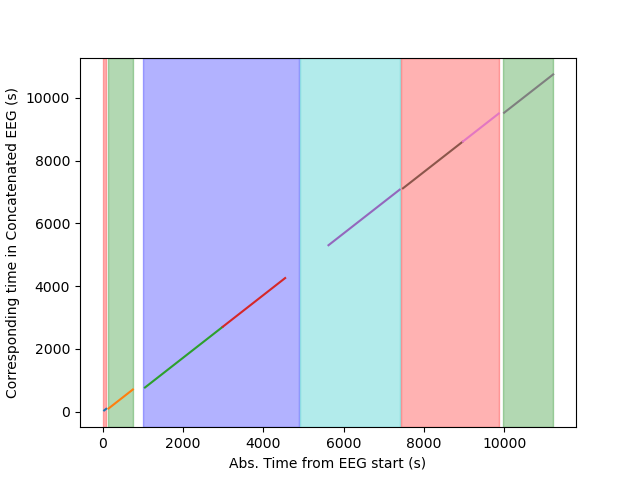

In [67]:
%matplotlib widget
# Plot concatenate EEG timestamps vs absolute time from experiment start with each OE recording overlaid in different colors
_, ax = plt.subplots()
for opti_rec in opti_ts_realign_df.Opti_Recording.unique():
    rec_df = opti_ts_realign_df[opti_ts_realign_df.Opti_Recording == opti_rec]
    ax.plot(rec_df["Tabs_from_eeg_start"], rec_df["Timestamps_realigned"])
ax.set_xlabel("Abs. Time from EEG start (s)")
ax.set_ylabel("Corresponding time in Concatenated EEG (s)")

colors = ['r', 'g', 'b', 'c']*4
for oe_rec in sync_df.Recording.unique():
    oe_rec_df = sync_df[sync_df.Recording == oe_rec]
    oe_start, oe_stop = oe_rec_df["Tabs from start (s)"].values
    ax.axvspan(oe_start, oe_stop, alpha=0.3, color=colors[int(oe_rec)])


### If above looks ok, then adjust dataframe and save.

Horizontal gaps should occur if you have an optitrack recording that spans two OE recordings, e.g. if OE had a disconnect but Motive ran throughout.

Diagonal gaps should occur if you started and stopped both Motive and OE in the same period.

In [68]:
opti_ts_realign_df = opti_ts_realign_df.rename(columns={"Timestamps": "abs_time_from_eeg_start", 
                                                        "Timestamps_realigned": "eeg_aligned_times"})
opti_ts_realign_df.to_csv(sess.filePrefix.with_suffix(".opti_times_aligned.csv"))
np.save(sess.filePrefix.with_suffix(".opti_times_aligned.npy"), opti_ts_realign_df, allow_pickle=True)